# Making the seas more secure

## Detection of high traffic image

In this notebook we will show you how to track maritime traffic easily and efficiently, using sentinel-1 GRD for detection and sentinel-2 L1C for verification.

### 1. Image request

#### Imports

In [1]:
from mundilib import MundiCatalogue

# other tools
import cv2
import os
from PIL import Image
from utils import height2width
import numpy as np
from osgeo import gdal
import matplotlib.pyplot as plt

#### Choice of satellite

In [2]:
c = MundiCatalogue()
wms = c.get_collection("Sentinel1").mundi_wms('GRD') # choice of satellite

#### Define WMS parameters

In [3]:
_projection_ = 'EPSG:4326'
_bbox_       = (32.495087,29.877812,32.558258,29.928541) # bbox Suez canal
_time_       = '2021-03-27'

_height_     = 600
_width_      = 1200

#### GetMap: Visualisation of layers 3 from bbox of Suez Canal

IW - VV [dB gamma0]


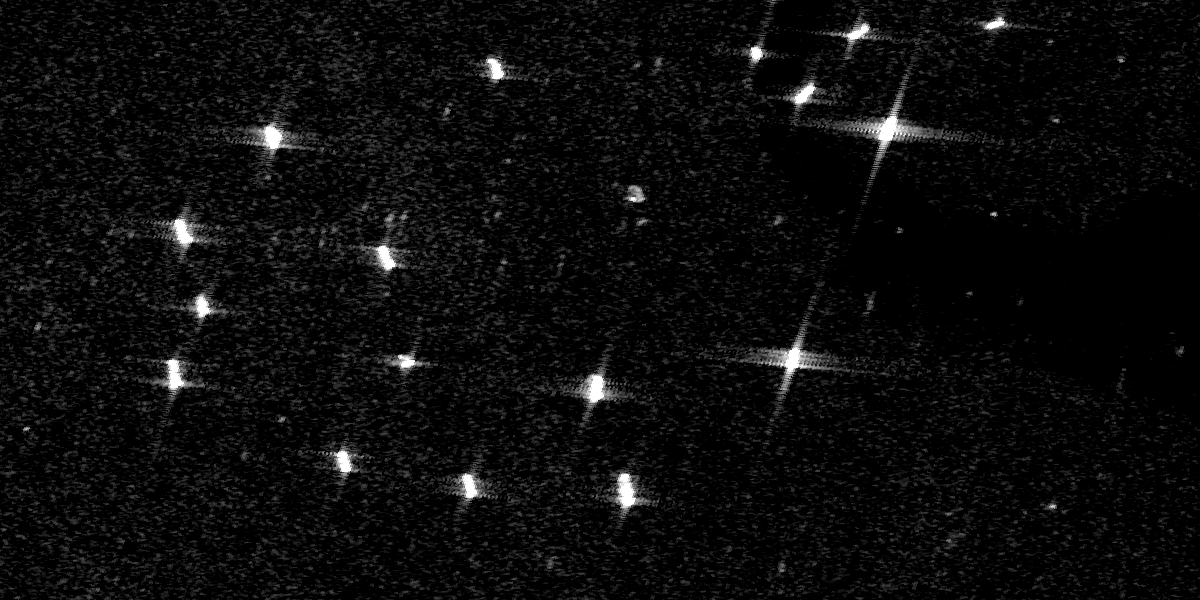

In [4]:
layers = list(wms.contents)

print (wms[layers[3]].title)

# getting image from 'wms'
img1 = wms.getmap(layers = [wms[layers[3]].name],
                         srs = _projection_,
                         bbox = _bbox_,
                         size = (_width_, _height_),
                         format ='image/png',
                         time = _time_,
                         showlogo = False,
                         transparent=False)

#display image
display(Image.open(img1))

We can see on this picture that there are white dots that represent the boats, we will see in this notebook how to put them in evidence and count them.

### Informations about image with GDAL

This part is useful to show how to get information about the image with GDAL.

In [5]:
data = img1.read()
vsipath = '/vsimem/img'
gdal.FileFromMemBuffer(vsipath, data)
raster_ds = gdal.Open(vsipath)
print (type(raster_ds))
       
# Dimensions
print ("X: ", raster_ds.RasterXSize)
print ("Y: ", raster_ds.RasterYSize)

# Number of bands
print ("Nb of bands: ", raster_ds.RasterCount)

# band informations
print ("Bands information:")
for band in range(raster_ds.RasterCount):
    band += 1
    srcband = raster_ds.GetRasterBand(band)
    if srcband is None:
        continue
    stats = srcband.GetStatistics( True, True )
    if stats is None:
        continue
    print (" - band #%d : Minimum=%.3f, Maximum=%.3f, Mean=%.3f, StdDev=%.3f" % ( \
                band, stats[0], stats[1], stats[2], stats[3] ))

<class 'osgeo.gdal.Dataset'>
X:  1200
Y:  600
Nb of bands:  2
Bands information:
 - band #1 : Minimum=0.000, Maximum=255.000, Mean=12.273, StdDev=28.625
 - band #2 : Minimum=255.000, Maximum=255.000, Mean=255.000, StdDev=0.000


In [6]:
# Getting first band of the raster as separate variable
band1 = raster_ds.GetRasterBand(1)  

# Print only selected metadata:
print ("No data value :", band1.GetNoDataValue()) # none
print ("Min value     :", band1.GetMinimum())
print ("Max value     :", band1.GetMaximum())

No data value : None
Min value     : 0.0
Max value     : 255.0


In [7]:
band1_ds = band1.ReadAsArray()#convert image to array

print ("\n--- raster content ---")
print (band1_ds[1:10, ])


--- raster content ---
[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [36 38 38 ...  0  0  0]
 [43 43  0 ...  0  0  0]
 [23 23  0 ...  0  0  0]]


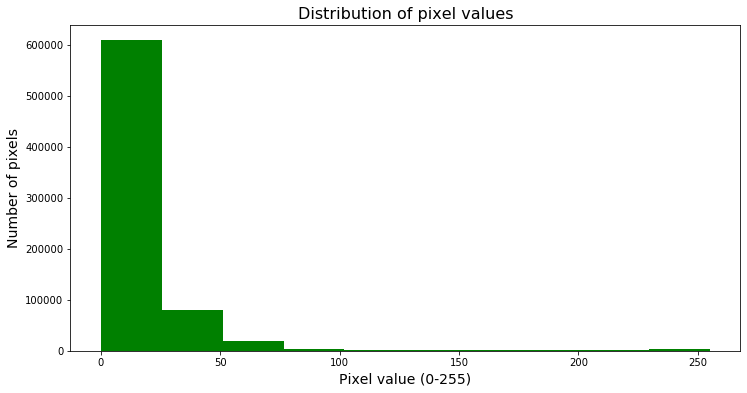

In [8]:
band1_hist_ds = band1_ds.ravel()
band1_hist_ds = band1_hist_ds[~np.isnan(band1_hist_ds)]

# Histogram parameter
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
axes.hist(band1_hist_ds, bins=10, histtype='stepfilled', color='green')

axes.set_title("Distribution of pixel values", fontsize=16)
axes.set_xlabel('Pixel value (0-255)', fontsize=14)
axes.set_ylabel('Number of pixels', fontsize=14)  

plt.show()

### Masking with raster image

This step will allow us to have only 2 pixel values 0 or 255.

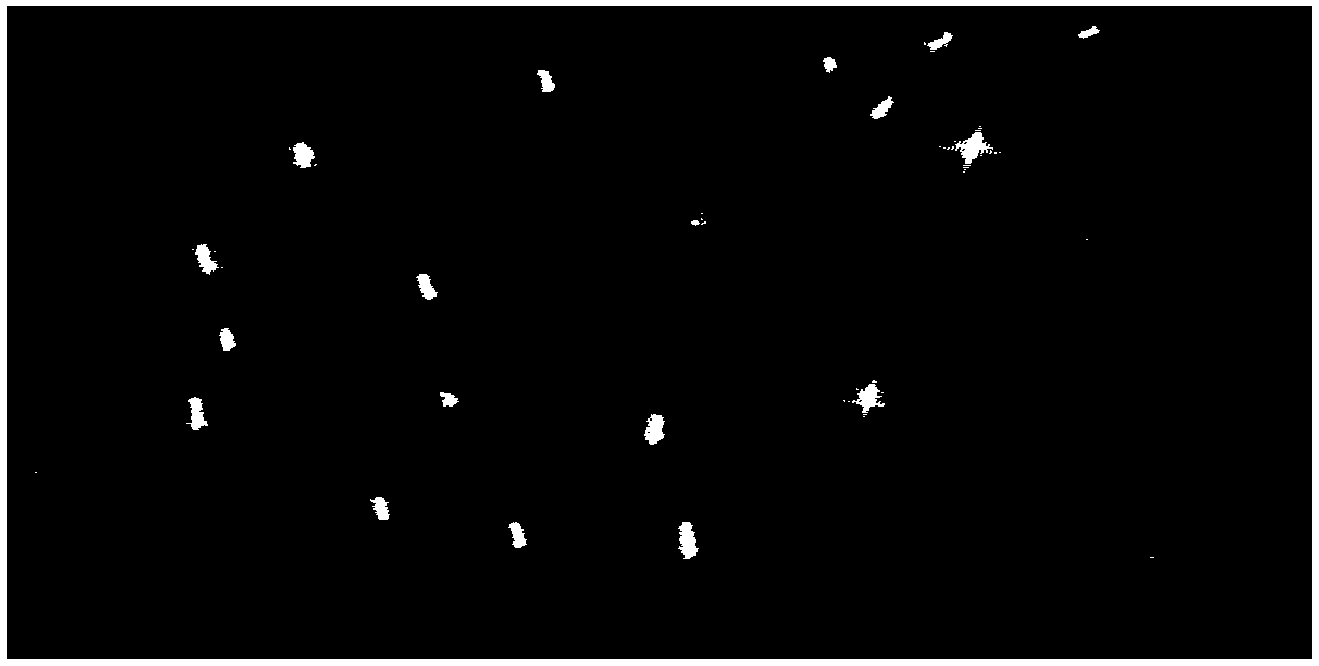

In [9]:
# Replace the pixels
img_matrix = np.array(band1_ds)
img_matrix[img_matrix <= 180] = 0
img_matrix[img_matrix > 180] = 255

masked_array = np.ma.masked_where(img_matrix>255, img_matrix)
plt.figure(figsize = (24,12))
plt.axis('off')
plt.imshow(masked_array,cmap='gray', interpolation='nearest')

plt.show()

The image is now filtered and is much more readable and it will be easier to count the boats.

#### informations about the masking

In [10]:
Total = ((masked_array <=0) + (masked_array >= 255)).sum()

White_Pixel = (masked_array >=255).sum() # Number of white pixels
Black_Pixel = (masked_array <=0).sum() # Number of black pixels

Percentage_White = round(((White_Pixel / Total) * 100), 2) # Percentage of white pixels
Percentage_Black = round(((Black_Pixel / Total) * 100), 2) # Percentage of black pixels

print ("number of white pixel : ", '\033[1m' + ("%d"%White_Pixel) + '\033[0m')
print ("number of black pixel : ", '\033[1m' + ("%d"%Black_Pixel) + '\033[0m')
print ("Total of pixel: ", '\033[1m' + ("%d"%Total) + '\033[0m')

print ("----------------")

print ("percentage of white pixel : ", '\033[1m' + ("%.2f"%Percentage_White) + "%" + '\033[0m')
print ("percentage of black pixel: ", '\033[1m' + ("%.2f"%Percentage_Black) + "%" + '\033[0m')

number of white pixel :  4683
number of black pixel :  715317
Total of pixel:  720000
----------------
percentage of white pixel :  0.65%
percentage of black pixel:  99.35%


##### Open CV

Thanks to openCV, we were able to surround all the clusters with white pixels in the image.

Number of clusters : 17


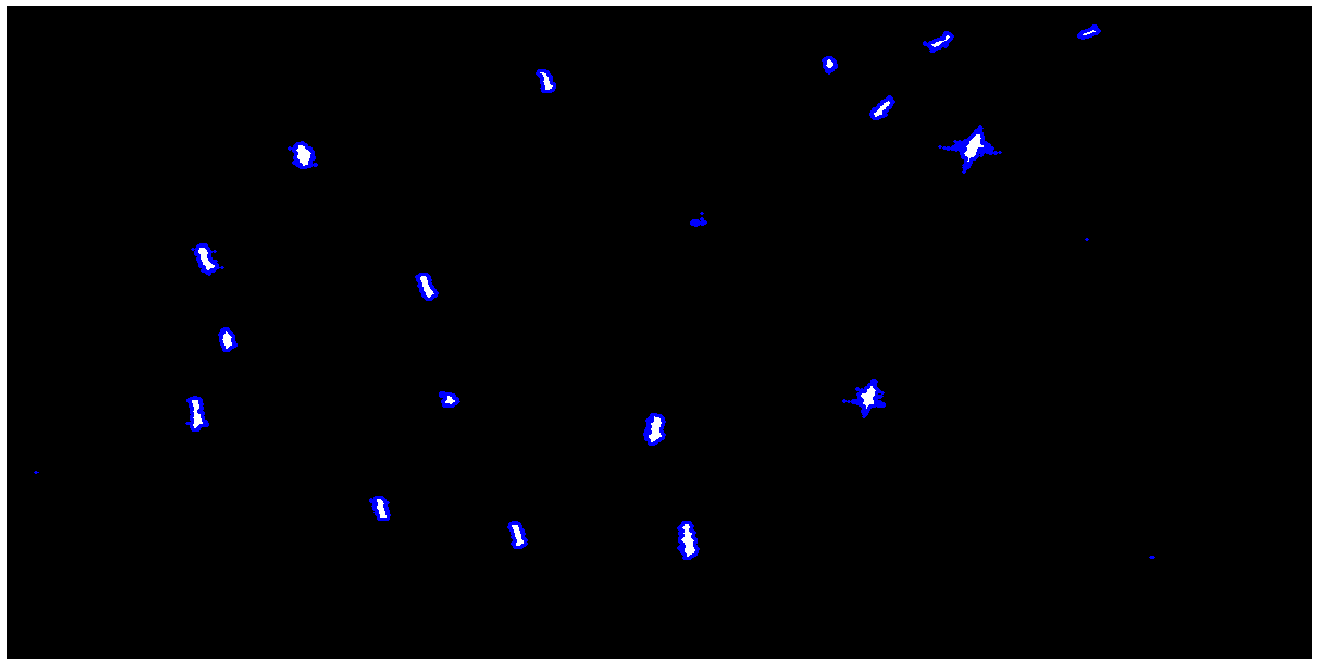

In [11]:
image = cv2.cvtColor(img_matrix, cv2.COLOR_BGR2RGB)

# Apply a threshold to identify white pixel clusters
seuil = 20

# Apply a contour filter to identify clusters
contours, hierarchy = cv2.findContours(masked_array, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
image = cv2.drawContours(image, contours , -1, (0, 0, 255), 2)

# Count the number of clusters with more white pixels than the threshold
count = 0
for contour in contours:
    contour_area = cv2.contourArea(contour)
    if contour_area >= seuil:
        count += 1
        
# Display the number of clusters identified
print("Number of clusters :", count)

# Display image with contours
plt.figure(figsize = (24,12))
plt.axis('off')
plt.imshow(image)
plt.show()

There are 17 clusters found composed of 20 or more white pixels. So 17 boats found.

#### Comparison with sentinel 2

To check if a point represents a boat we can get a sentinel-2 grd image at the same date and location (if possible).
Sentinel 2 allows to see better the boats on the water. We can also apply an NDWI filter that allows us to see the boats better.

In [17]:
s2 = MundiCatalogue()
wms = s2.get_collection("Sentinel2").mundi_wms('L1C') # choice of satellite

# The parameters are the same as before
_projection_ = 'EPSG:4326'
_bbox_       = (32.495087,29.877812,32.558258,29.928541)# bbox Suez canal
_time_       = '2021-03-27'# same date as the sentinel-1 image but with a few hours difference
_height_     = 600
_width_      = 1200

layers = list(wms.contents)

# getting image from 'wms'
img_NDWI = wms.getmap(layers = [wms[layers[13]].name],#Layers 13 : NDWI index
                         srs = _projection_,
                         bbox = _bbox_,
                         size = (_width_, _height_),
                         format ='image/png',
                         time = _time_,
                         showlogo = False,
                         transparent=False)

We use the NDWI index because it allows us to better see the boats in a sentinel-2 image.

sentinel-2 image with NDWI index


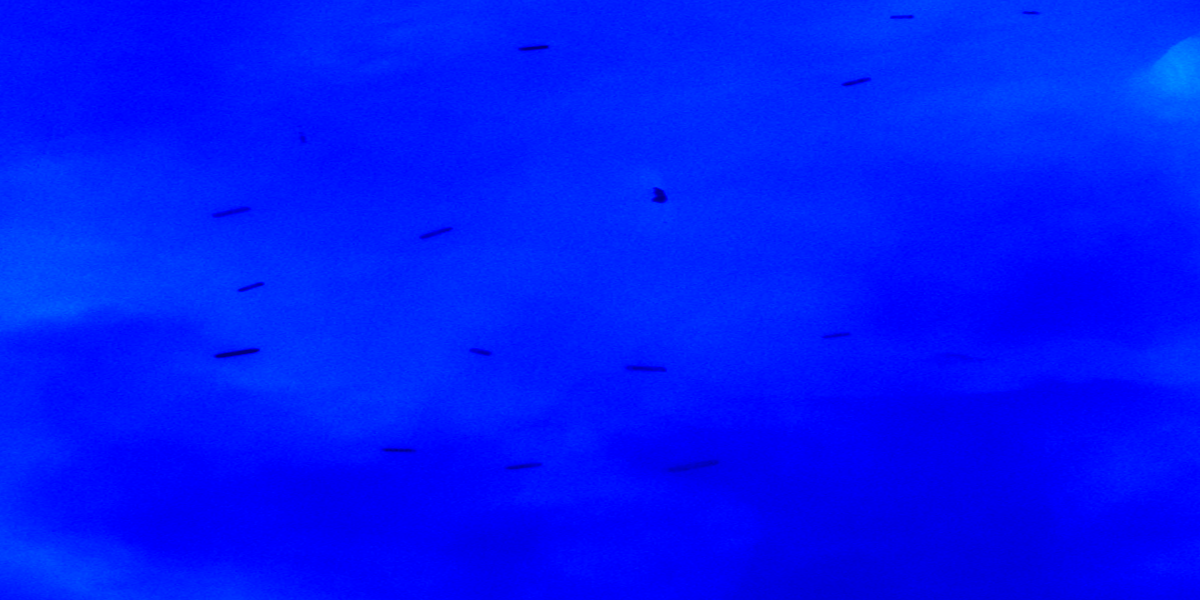

sentinel-1 image


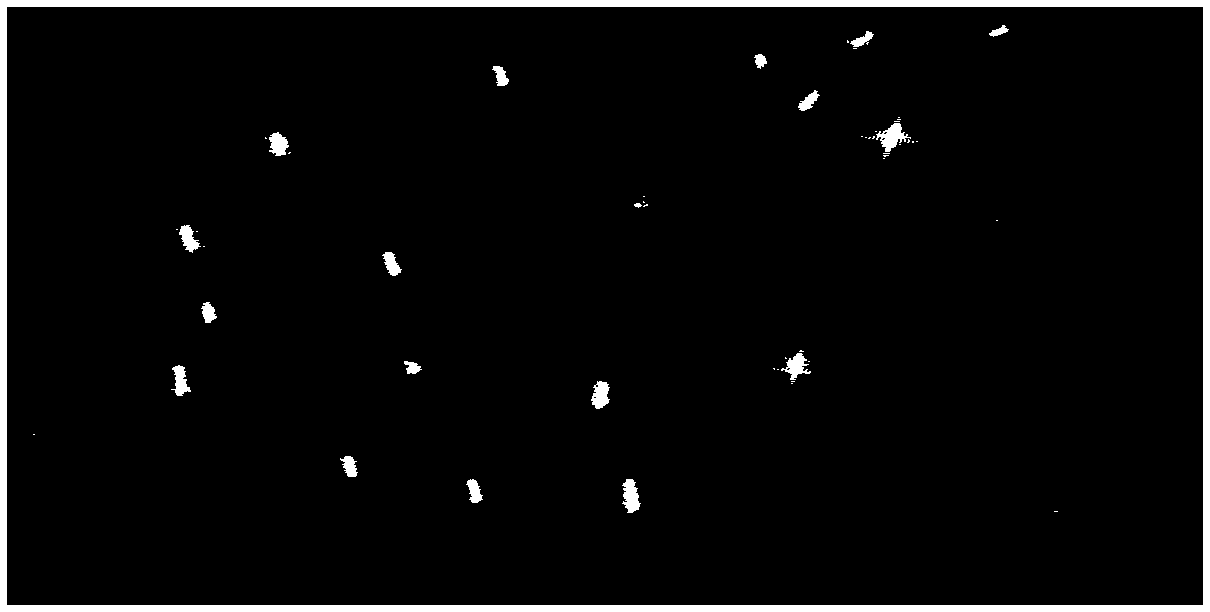

In [18]:
# display sentinel-2 image
print("sentinel-2 image with NDWI index")
display(Image.open(img_NDWI))

# display sentinel-1 image
print("sentinel-1 image")
plt.figure(figsize = (22,11))
plt.axis('off')
plt.imshow(img_matrix, cmap="gray")
plt.show()

#### Sentinel-2 with natural colors

Finally here is the natural color image of sentinel-2 which also allows to visualize the boats very well.

sentinel-2 image with natural color


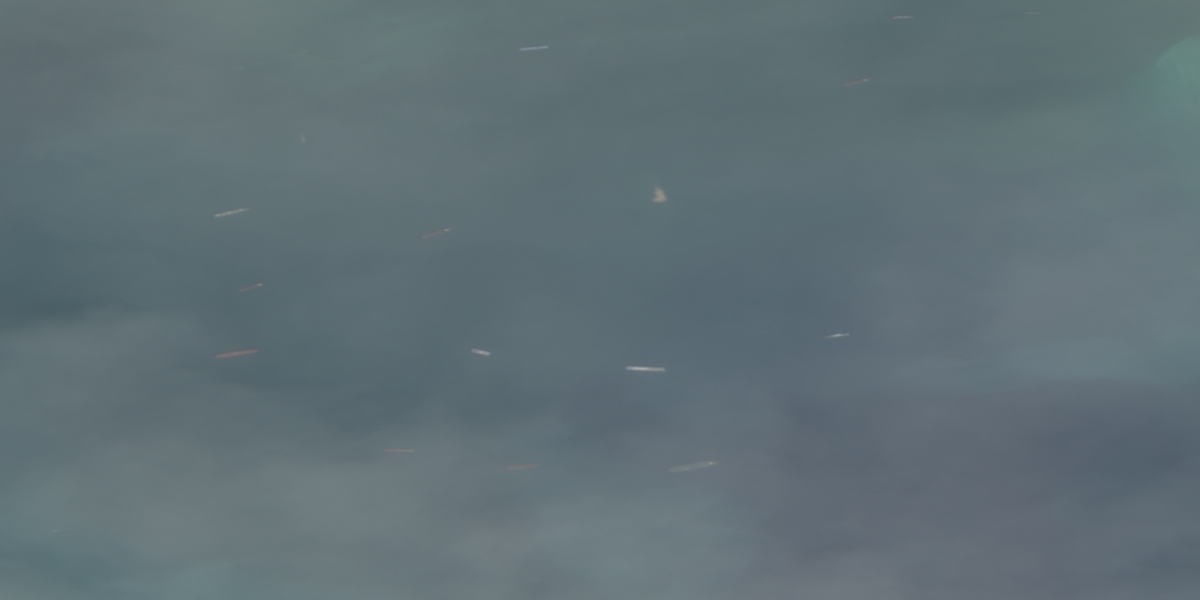

In [19]:
s2 = MundiCatalogue()
wms = s2.get_collection("Sentinel2").mundi_wms('L1C') # choice of satellite

# The parameters are the same as before
_projection_ = 'EPSG:4326'
_bbox_       = (32.495087,29.877812,32.558258,29.928541)
_time_       = '2021-03-27'
_height_     = 600
_width_      = 1200

layers = list(wms.contents)

# getting image from 'wms'
img_NC = wms.getmap(layers = [wms[layers[1]].name],# 1 Natural Colors
                         srs = _projection_,
                         bbox = _bbox_,
                         size = (_width_, _height_),
                         format ='image/png',
                         time = _time_,
                         showlogo = False,
                         transparent=False)

print("sentinel-2 image with natural color")
display(Image.open(img_NC))